In [2]:
# Importing required functions 
import random
import matplotlib.pyplot as plt

from flask import Flask, render_template 
from bokeh.embed import components 
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [3]:
import pandas as pd
import numpy as np
import yaml
import statistics

#Config-bestand laden als dictionary zodat buiten de functie alle opties
#als key+waarde behandeld kunnen worden
def get_config():
    with open("config.yaml", 'r') as stream:
        config = yaml.safe_load(stream)
    return config

config = get_config()

df = config["weight_file"]
df = pd.read_csv("updated_Data_Results(Jean).csv", sep=';', decimal=',')
richarddf = pd.read_csv("updated_Data_Results(Richard).csv", sep=';', decimal=',')

In [4]:
blankIndex = [''] * len(df)
df.index = blankIndex

# Ontbrekende waardes (NaN) aanpassen naar lege cellen
#df = df.fillna("")
df.head()

,Date\Parameters,Day,Intake Dose,Test Type,Weight (Kg),BMI (kg/m2),RMI (kcal),Fat Visceral (%),Body Fat (%),Muscle (%),...,Unnamed: 17,Unnamed: 18,Glucose(mmol/l),Unnamed: 20,Unnamed: 21,Micro_Biome,Unnamed: 23,Unnamed: 24,Additional remarks,Unnamed: 26
,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,Average,1.0,2.0,Average,1.0,2.0,Average,NaN,NaN
,28-11-2024,Thursday,half-Dose (10days),BaseLine-Test,79.4,22.5,1774.0,3.0,"16,10%",41.7,...,NaN,NaN,3.8,3.8,"3,8",NaN,NaN,NaN,Eaten breakfast (7:15 AM) before glucose measu...,NaN
,29-11-2024,Friday,half-Dose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
,30-11-2024,Saturday,half-Dose,NaN,79.1,22.4,1768.0,4.0,"16,7",41.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
,1-12-2024,Sunday,half-Dose,NaN,78.1,22.1,1752.0,4.0,17,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
startdate = df['Date\Parameters '].iloc[1]
startdate = pd.to_datetime(startdate, format='%d-%m-%Y')
dates = pd.to_datetime((df['Date\Parameters ']), format='%d-%m-%Y')
#print(dates)
df['Days'] = (dates - startdate) / np.timedelta64(1, 'D')

# Ontbrekende waardes verwijderen en sorteren op basis van naam van dosis
df.dropna(subset=['Weight (Kg)'], inplace=True)

# Nieuw dataframe met alleen vereiste kolommen toevoegen
df2 = pd.DataFrame(columns=['Dose','Date','Weight'])

# Vereiste kolommen maken
df2['Dose'] = df['Intake Dose']
df2['Date'] = df['Date\Parameters ']
df2['Weight'] = df['Weight (Kg)']
df2['BMI'] = df['BMI (kg/m2)']
df2['RMI'] = df['RMI (kcal)']
df2['Fat'] = df['Body Fat (%)']
df2['Muscle'] = df['Muscle (%)']
df2['hr'] = df['Heart rate']
df2['bp (dia)'] = df['Blood Pressure(diastolic) (mmHg)']
df2['bp (sys)'] = df['Blood Pressure(systolic) (mmHg)\n']

# Nieuwe dag kolom maken
startdate = df2['Date'].iloc[0]
startdate = pd.to_datetime(startdate, format='%d-%m-%Y')
dates = pd.to_datetime((df2['Date']), format='%d-%m-%Y')
df2['Days'] = (dates - startdate) / np.timedelta64(1, 'D')

# Categorieën maken voor de data
def my_func(x):
    if x['Days'] <= 10 and x['Days'] > 0:
        return "1st Half Dose"
    if x['Days'] <= 21 and x['Days'] >= 11:
        return "1st Full Dose"
    if x['Days'] <= 42 and x['Days'] >= 22:
        return "2st Half Dose"
    if x['Days'] <= 63 and x['Days'] >= 43:
        return "2st Full Dose"

df2['Dosage Type'] = df2.apply(lambda x: my_func(x), 1)
df2 = df2.dropna()

In [48]:
# Importing required functions 
import random 
import statistics as st
import seaborn as sns
import matplotlib.pyplot as plt
import base64

from flask import Flask, render_template, request  
from io import BytesIO

# Flask constructor 
app = Flask(__name__) 

# Root endpoint 
@app.route('/') 
def homepage():
    typ = request.args.get('param', default = 'Weight', type = str)
    dose_types = df2['Dosage Type'].unique()
    max_values = df2.groupby(['Dosage Type'], sort=False)[typ].max()
    min_values = df2.groupby(['Dosage Type'], sort=False)[typ].min()
    avg_values = df2.groupby(['Dosage Type'], sort=False)[typ].mean()
    std_values = df2.groupby(['Dosage Type'], sort=False)[typ].std()
    summary_dict = {'dose_types': dose_types, 'avg_values': avg_values, 'std_values': std_values, 'min_values': min_values, 'max_values': max_values}
    summary = result = pd.DataFrame(summary_dict)
    parameters = df2.columns.values
    #fig = sns.heatmap([[1,2],[3,4]]).get_figure()
    #fig = sns.barplot(df2, x="Dosage Type", y=typ)
    box_plot = sns.boxplot(data=df2, x="Dosage Type", y=typ, width=0.8)

    # Gemiddelde berekenen voor verticale lijn
    average = st.mean(df2[typ])
    plt.axhline(average, color="orange")

    medians = df2.groupby(['Dosage Type'])['Weight'].mean()
    vertical_offset = df2['Weight'].mean() * 0.05 # offset from median for display

    box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=40, ha="right")
    pic_IObytes = BytesIO()
    box_plot.figure.savefig(pic_IObytes,  format='png')
    box_plot.figure.clf()
    pic_IObytes.seek(0)
    pic_pash = ''
    pic_hash = base64.b64encode(pic_IObytes.read()).decode("utf-8")
    
    # Return all the charts to the HTML template 
    return render_template('charts.html', parameters=parameters, pic_hash=pic_hash, summary=summary, typ=typ)


# Main Driver Function 
if __name__ == '__main__': 
    # Run the application on the local development server 
    app.run() 


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
/tmp/ipykernel_198850/626802876.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=40, ha="right")
127.0.0.1 - - [25/Feb/2025 11:38:43] "GET /?param=BMI HTTP/1.1" 200 -
/tmp/ipykernel_198850/626802876.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=40, ha="right")
127.0.0.1 - - [25/Feb/2025 11:38:46] "GET /?param=Weight HTTP/1.1" 200 -
[2025-02-25 11:38:49,315] ERROR in app: Exception on / [GET]
Traceback (most recent call last):
  File "/home/jeannovy/.local/lib/python3.11/site-packages/pandas/core/groupby/groupby.py", line 1942, in _agg_py_fallback
    res_values = self._grouper.agg_series(ser, alt, preserve_dtype=True)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jeannovy/.local/lib/python3.11/si

127.0.0.1 - - [25/Feb/2025 13:41:28] "GET /?param=Fat HTTP/1.1" 500 -
/tmp/ipykernel_198850/626802876.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=40, ha="right")
127.0.0.1 - - [25/Feb/2025 13:41:34] "GET /?param=Muscle HTTP/1.1" 200 -


<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_198850/1575581864.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=40, ha="right")


[Text(0, 0, '1st Half Dose'),
 Text(1, 0, '1st Full Dose'),
 Text(2, 0, '2st Half Dose'),
 Text(3, 0, '2st Full Dose')]

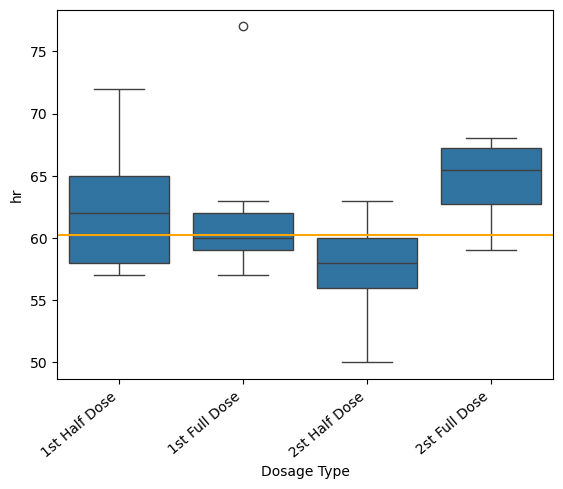

In [42]:
parameter = "hr"
box_plot.figure.clf()
box_plot = sns.boxplot(data=df2, x="Dosage Type", y=parameter, width=0.8)

# Gemiddelde berekenen voor verticale lijn
average = st.mean(df2[parameter])
plt.axhline(average, color="orange")

medians = df2.groupby(['Dosage Type'])['Weight'].mean()
vertical_offset = df2['Weight'].mean() * 0.05 # offset from median for display

box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=40, ha="right")

In [28]:
type(summary)

pandas.core.frame.DataFrame

In [10]:
typ = 'Weight'
dose_types = df2['Dosage Type'].unique()
max_values = df2.groupby(['Dosage Type'], sort=False)[typ].max()
min_values = df2.groupby(['Dosage Type'], sort=False)[typ].min()
avg_values = df2.groupby(['Dosage Type'], sort=False)[typ].mean()
std_values = df2.groupby(['Dosage Type'], sort=False)[typ].std()
summary_dict = {'Average': avg_values, 'Standard Deviation': std_values, 'Minimum': min_values, 'Maximum': max_values}
summary = result = pd.DataFrame(summary_dict)

In [21]:
summary

,Average,Standard Deviation,Minimum,Maximum
Dosage Type,,,,
1st Half Dose,79.022222,0.580469,78.1,79.7
1st Full Dose,79.372727,0.471362,78.6,80.0
2st Half Dose,79.228571,0.592573,78.2,80.2
2st Full Dose,78.475000,0.745542,77.6,79.4


In [14]:
for index, row in summary.iterrows():
    #row['Dosage Type']
    print(row['Average'])
    print(row['Standard Deviation'])

79.02222222222223
0.5804691589089368
79.37272727272727
0.4713616638864683
79.22857142857143
0.5925730816893888
78.475
0.745542308211508


<AxesSubplot: xlabel='Dosage Type', ylabel='BMI'>

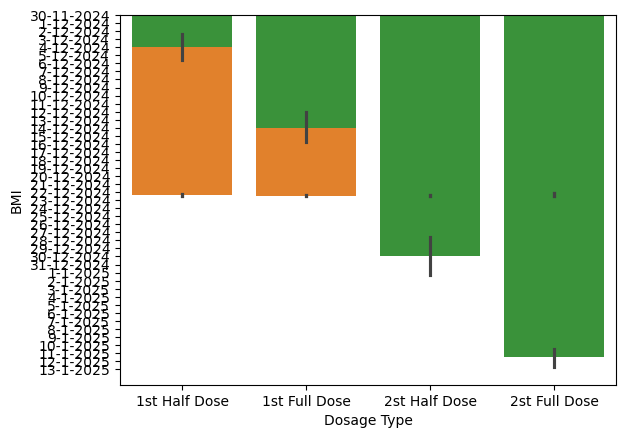

In [74]:
sns.barplot(df2, x="Dosage Type", y='BMI')
sns.barplot(df2, x="Dosage Type", y='BMI')
sns.barplot(df2, x="Dosage Type", y='Date')

In [50]:
print(df2.columns.values)

['Dose' 'Date' 'Weight' 'BMI' 'RMI' 'Fat' 'Muscle' 'hr' 'bp (dia)'
 'bp (sys)' 'Days' 'Dosage Type']


iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAYAAAA10dzkAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAgUUlEQVR4nO3df4zV5Z0v8M+p4MFtAVcs41BLhLhx6RhYd2jW6V2sLhUDG6I33Gxz06pr02Znl+rqhE0z+AdwN2aaXRKp0TKyxR+Ube3mTrEYLYGbOKAVEgaHrO0qSVMqLnemhOwWK2kPP+bcP1y5HvkxX5jDnOF5Xq/k+8d5zvd8z3OMY95+Ps/z/Zaq1Wo1AADIxscaPQEAAEaXAAgAkBkBEAAgMwIgAEBmBEAAgMwIgAAAmREAAQAyIwACAGRGAAQAyIwACACQGQEQACAzAiAAQGYEQACAzAiAAACZEQABADIjAAIAZEYABADIjAAIAJAZARAAIDMCIABAZgRAAIDMCIAAAJkRAAEAMiMAAgBkRgAEAMiMAAgAkBkBEAAgMwIgAEBmBEAAgMwIgAAAmREAAQAyIwACAGRGAAQAyIwACACQGQEQACAzAiAAQGYEQACAzAiAAACZEQABADIjAAIAZEYABADIjAAIAJAZARAAIDMCIABAZgRAAIDMCIAAAJkRAAEAMiMAAgBkRgAEAMiMAAgAkBkBEAAgMwIgAEBmBEAAoG66urqiVCrFgw8+eM7ztm/fHq2trTFhwoSYOXNmdHd3j84EiQgBEACok927d8e6deti9uzZ5zxv//79sWjRopg3b1709/fH8uXL44EHHoienp5RmikCIAAwYu+991586Utfin/6p3+K3//93z/nud3d3TF9+vRYs2ZNzJo1K7761a/GV77ylVi9evUozRYBEAAYsaVLl8af//mfxxe+8IVhz925c2csWLCgZuyOO+6Ivr6+OH78+MWaIh8yrtETAADGnkqlEpVKpWas

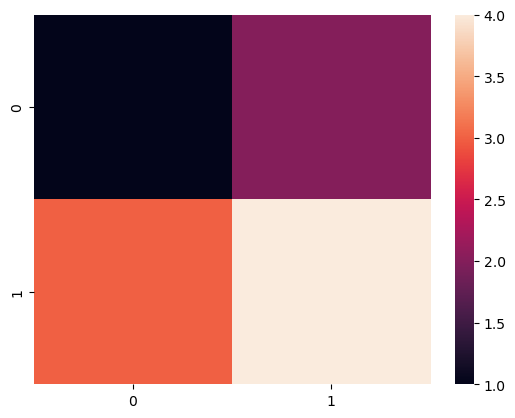

In [36]:
#fig = sns.heatmap([[1,2],[3,4]]).get_figure()
#fig.savefig(s, format='png')
#fig.close()
#s = base64.b64encode(s.getvalue()).decode("utf-8").replace("\n", "")
#print('<img align="left" src="data:image/png;base64,%s">' % s)

fig = sns.heatmap([[1,2],[3,4]]).get_figure()
pic_IObytes = BytesIO()
fig.savefig(pic_IObytes,  format='png')
s = base64.b64encode(pic_IObytes.getvalue()).decode("utf-8")
print(s)
#base64.b64encode(pic_IObytes.getvalue()).decode("utf-8")
#print('<img align="left" src="data:image/png;base64,%pic_IObytes">' % pic_IObytes)


In [35]:
import io
import base64
import matplotlib.pyplot as plt
s = io.BytesIO()
plt.plot(list(range(100)))
plt.savefig(s, format='png', bbox_inches="tight")
plt.close()
s = base64.b64encode(s.getvalue()).decode("utf-8")
#print('<img align="left" src="data:image/png;base64,%s">' % s)
s

'iVBORw0KGgoAAAANSUhEUgAAAigAAAGdCAYAAAA44ojeAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAA9hAAAPYQGoP6dpAAA/7UlEQVR4nO3dd3xUdd7+/9ekTQpJIAQSQgIECUUCJAFFERcsYEPFQgu6urv3/dWFABGVYgVXErGgC0F2dXfdogFEUNG1gA1BVkFSgNB7KCHUFNJnPr8/vM1vA6iUSc5kcj0fj/kjZ04mVz6GOZfnPXPGZowxiIiIiLgRL6sDiIiIiJxOBUVERETcjgqKiIiIuB0VFBEREXE7KigiIiLidlRQRERExO2ooIiIiIjbUUERERERt+NjdYAL4XQ6OXjwIMHBwdhsNqvjiIiIyDkwxlBSUkJUVBReXj9/jqRRFpSDBw8SExNjdQwRERG5APn5+URHR//sPo2yoAQHBwM//IIhISEWpxEREZFzUVxcTExMTO1x/Oc0yoLy41gnJCREBUVERKSROZeXZ+hFsiIiIuJ2VFBERETE7aigiIiIiNtRQRERERG3o4IiIiIibkcFRURERNzOeReUr7/+mltvvZWoqChsNhvvvfdenfuNMUybNo2oqCgCAgIYOHAgeXl5dfaprKxk3LhxhIeHExQUxG233cb+/fsv6hcRERERz3HeBeXUqVP06tWLjIyMs97//PPPM2vWLDIyMli7di2RkZEMGjSIkpKS2n1SU1N59913WbBgAatWraK0tJQhQ4bgcDgu/DcRERERj2EzxpgL/mabjXfffZehQ4cCP5w9iYqKIjU1lcmTJwM/nC2JiIhg5syZPPDAAxQVFdGqVSv+9a9/MWLECOD/v3T9Rx99xA033PCLP7e4uJjQ0FCKiop0oTYREZFG4nyO3y59Dcru3bspKChg8ODBtdvsdjsDBgxg9erVAKxbt47q6uo6+0R